Introduction 

train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.

(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)



from doing an intial EDA and model training the models is stuck at around 70 percent for the validation data, while the training data is overfitting, after doing some hyperparameter tuning. According to the confustion metrics of various iterations of model tuning, the model is able to identify the positive emotions, but not the negative emotions so the goal is to make two models and them merge them for better category identification

The dataset is unbalanced so a good metric is recall , since if this was used in the healthcare context such as identifying possible depression signs, reducing false negtives those that where predicted to be negative but are actually positive -- like is someone was sad but was identified as happy.

## EDA

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import sklearn.metrics

import io
import itertools

from tensorflow.keras.metrics import Precision, Recall

from sklearn.utils import class_weight






In [2]:
%load_ext tensorboard

In [3]:
# check to see if gpu is avalaible
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
df = pd.read_csv("icml_face_data.csv")


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


the pixels columns is a string and needs to converted to numeric

In [6]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [7]:
df[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [8]:
df.shape

(35887, 3)

array([[<AxesSubplot: title={'center': 'emotion'}>]], dtype=object)

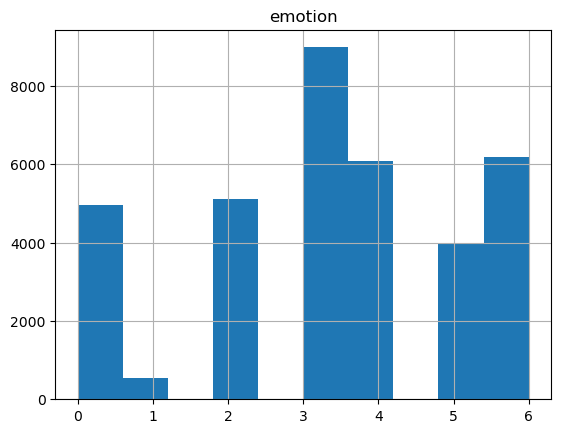

In [9]:
df.hist()

training category

In [10]:
df.loc[df[' Usage'] == 'Training'].shape

(28709, 3)

In [11]:
df.loc[df[' Usage'] == 'Training'].emotion.value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

training category

In [12]:
df.loc[df[' Usage'] == 'PublicTest'].shape

(3589, 3)

In [13]:
df.loc[df[' Usage'] == 'PublicTest'].emotion.value_counts()

3    895
4    653
6    607
2    496
0    467
5    415
1     56
Name: emotion, dtype: int64

private test

In [14]:
df.loc[df[' Usage'] == 'PrivateTest'].shape

(3589, 3)

In [15]:
df.loc[df[' Usage'] == 'PrivateTest'].emotion.value_counts()

3    879
6    626
4    594
2    528
0    491
5    416
1     55
Name: emotion, dtype: int64

In [16]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

## Data Wrangling 

In [17]:
# Function that inputs a series of numerical strings separated
# by a " " and returns a numpy array 

def convert_to_numpy(x):
   
    pixel_arr = []
    
    # convert string to a list of strings
    pixels_list=x.str.split(' ')

    for _ in pixels_list:
        pixel_arr.append(pd.to_numeric(_))

    pixels_num = np.array(pixel_arr)

    return pixels_num

the square root of 2304 is 48, so the pixels need to be reshapped into 48 X 48 using the reshape method

drop group 1

So the training dataset is unbalanced in regards to the 1 and 3 categories. These need to be rebalanced using some translation, etc of the data that is avalaible.

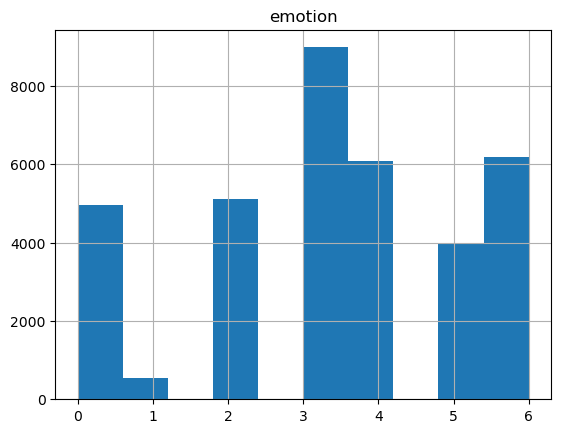

In [18]:
df.hist();

In [19]:
df.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [20]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

the label 1 needs to be dropped since there are not that many training examples

In [21]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [22]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [23]:
# drop the one category
df = df[df['emotion'] != 1].copy()

In [24]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
Name: emotion, dtype: int64

need to remap the emotion categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

need (0=Angry, 1=Fear, 2=Happy, 3=Sad, 4=Surprise, 5=Neutral)
remap: 

In [25]:
dic_replace = {2:1, 3:2, 4:3, 5:4, 6:5}

df['emotion'].replace(dic_replace, inplace=True)

need to remap the emotion categories (0=Angry, 1=Disgust, 1=Fear, 2=Happy, 3=Sad, 4=Surprise, 6=Neutral)

In [26]:
df['emotion'].value_counts()

2    8989
5    6198
3    6077
1    5121
0    4953
4    4002
Name: emotion, dtype: int64

training data 

In [27]:
train_df = df.loc[df[' Usage'] == 'Training']

In [28]:
train_df

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,1,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,3,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,5,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
28704,1,Training,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,0,Training,114 112 113 113 111 111 112 113 115 113 114 11...
28706,3,Training,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,0,Training,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


In [29]:
train_df = train_df.drop([' Usage'], axis=1)

if we drop this row we need to recode the categorize so for now we will leave it

In [30]:
train_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,1,231 212 156 164 174 138 161 173 182 200 106 38...
3,3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,5,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


validation data

In [31]:
valid_df = df.loc[df[' Usage'] == 'PrivateTest']

In [32]:
valid_df = valid_df.drop(' Usage', axis=1)

In [33]:
valid_df.head()

,emotion,pixels
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...
32299,4,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...
32300,5,232 240 241 239 237 235 246 117 24 24 22 13 12...
32301,3,200 197 149 139 156 89 111 58 62 95 113 117 11...
32302,1,40 28 33 56 45 33 31 78 152 194 200 186 196 20...


test data

In [34]:
test_df = df.loc[df[' Usage'] == 'PublicTest']
test_df = test_df.drop(' Usage', axis=1)
test_df.head()

,emotion,pixels
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28711,3,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,5,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,2,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...
28714,2,235 233 223 109 34 37 34 31 28 38 56 69 106 13...


In [35]:
# Separate out our target values
y_train = train_df['emotion']
y_valid = valid_df['emotion']
y_test = test_df['emotion']

# Separate out our image vectors
x_train = convert_to_numpy(train_df[' pixels'])
x_valid = convert_to_numpy(valid_df[' pixels'])
x_test = convert_to_numpy(test_df[' pixels'])






In [36]:
y_test

28709    0
28711    3
28712    5
28713    2
28714    2
        ..
32293    3
32294    2
32295    3
32296    3
32297    3
Name: emotion, Length: 3533, dtype: int64

In [37]:
class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
            classes= np.unique(y_train), 
            y= y_train)

In [38]:
class_weights

array([1.17951606, 1.15015052, 0.65310695, 0.97560386, 1.48601913,
       0.94907687])

In [39]:

class_weights = dict(enumerate(class_weights))

In [40]:
class_weights

{0: 1.1795160617438465,
 1: 1.1501505166381905,
 2: 0.6531069531069531,
 3: 0.9756038647342995,
 4: 1.486019131714496,
 5: 0.9490768714333669}

In [41]:
type(class_weight)

module

In [42]:
y_train

0        0
1        0
2        1
3        3
4        5
        ..
28704    1
28705    0
28706    3
28707    0
28708    3
Name: emotion, Length: 28273, dtype: int64

In [43]:
# Turn our scalar targets into binary categories
num_classes = 6
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [44]:
y_train.shape

(28273, 6)

In [45]:
x_train

array([[ 70,  80,  82, ..., 106, 109,  82],
       [151, 150, 147, ..., 193, 183, 184],
       [231, 212, 156, ...,  88, 110, 152],
       ...,
       [ 74,  81,  87, ..., 188, 187, 187],
       [222, 227, 203, ..., 136, 136, 134],
       [195, 199, 205, ...,   6,  15,  38]], dtype=int64)

In [46]:
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

In [47]:
# Normalize our image data
x_train = np.divide(x_train, 255.0)
x_valid = np.divide(x_valid, 255.0)
x_test = np.divide(x_test, 255.0)

In [48]:
x_train

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.2901961 , 0.31764707, 0.34117648, ..., 0.7372549 , 0.73333335,
        0.73333335],
       [0.87058824, 0.8901961 , 0.79607844, ..., 0.53333336, 0.53333336,
        0.5254902 ],
       [0.7647059 , 0.78039217, 0.8039216 , ..., 0.02352941, 0.05882353,
        0.14901961]], dtype=float32)

set a certain range for train_test_split

In [49]:
x_train = x_train.reshape(-1,48,48,1)
x_valid = x_valid.reshape(-1,48,48,1)
x_test = x_test.reshape(-1,48,48,1)

In [50]:
x_train

array([[[[0.27450982],
         [0.3137255 ],
         [0.32156864],
         ...,
         [0.20392157],
         [0.16862746],
         [0.16078432]],

        [[0.25490198],
         [0.23921569],
         [0.22745098],
         ...,
         [0.21960784],
         [0.20392157],
         [0.17254902]],

        [[0.19607843],
         [0.16862746],
         [0.21176471],
         ...,
         [0.19215687],
         [0.21960784],
         [0.18431373]],

        ...,

        [[0.35686275],
         [0.25490198],
         [0.16470589],
         ...,
         [0.28235295],
         [0.21960784],
         [0.16862746]],

        [[0.3019608 ],
         [0.32156864],
         [0.30980393],
         ...,
         [0.4117647 ],
         [0.27450982],
         [0.18039216]],

        [[0.3019608 ],
         [0.28235295],
         [0.32941177],
         ...,
         [0.41568628],
         [0.42745098],
         [0.32156864]]],


       [[[0.5921569 ],
         [0.5882353 ],
         [0.57

## Creating the Convolution Model Layers

In [51]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


look into scikit learn weight generation for imbalanced classes

In [68]:
# it seems like playing with the dropout rate and number of layers, improve the metric
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()

#1st block
model.add(Conv2D(64, (3, 3),kernel_initializer='he_normal',bias_initializer='zeros', strides= (1,1), padding="same", activation="elu", 
                 input_shape=(48, 48, 1)))
model.add(BatchNormalization())
#model.add(MaxPool2D((2, 2), strides=(2,2), padding="same"))
#model.add(Dropout(0.4))
model.add(Conv2D(64, (3, 3), strides=(1,1), padding="same", activation="elu", kernel_initializer='he_normal',bias_initializer='zeros'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=(2,2), padding="same"))
model.add(Dropout(0.4))

#2nd block

model.add(Conv2D(128, (3, 3), strides=(1,1), padding="same", activation="elu", kernel_initializer='he_normal',bias_initializer='zeros'))
model.add(BatchNormalization())
#model.add(MaxPool2D((2, 2), strides=(2,2), padding="same"))
#model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), strides=(1,1), padding="same", activation="elu", kernel_initializer='he_normal',bias_initializer='zeros'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=(2,2), padding="same"))
model.add(Dropout(0.4))

#3nd block

model.add(Conv2D(128, (3, 3), strides=(1,1), padding="same", activation="elu", kernel_initializer='he_normal',bias_initializer='zeros'))
model.add(BatchNormalization())
#model.add(MaxPool2D((2, 2), strides=(2,2), padding="same"))
#model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), strides=(1,1), padding="same", activation="elu", kernel_initializer='he_normal',bias_initializer='zeros'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=(2,2), padding="same"))
model.add(Dropout(0.4))

#4th block

model.add(Conv2D(256, (3, 3), strides=(1,1), padding="same", activation="elu", kernel_initializer='he_normal',bias_initializer='zeros'))
model.add(BatchNormalization())
#model.add(MaxPool2D((2, 2), strides=(2,2), padding="same"))
#model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), strides=(1,1), padding="same", activation="elu", kernel_initializer='he_normal',bias_initializer='zeros'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=(2,2), padding="same"))
model.add(Dropout(0.4))

#5th block
model.add(Conv2D(256, (3, 3), strides=(1,1), padding="same", activation="elu", kernel_initializer='he_normal',bias_initializer='zeros'))
model.add(BatchNormalization())
#model.add(MaxPool2D((2, 2), strides=(2,2), padding="same"))
#model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), strides=(1,1), padding="same", activation="elu", kernel_initializer='he_normal',bias_initializer='zeros'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=(2,2), padding="same"))
model.add(Dropout(0.4))

#5th block
model.add(Conv2D(256, (3, 3), strides=(1,1), padding="same", activation="elu", kernel_initializer='he_normal',bias_initializer='zeros'))
model.add(BatchNormalization())
#model.add(MaxPool2D((2, 2), strides=(2,2), padding="same"))
#model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), strides=(1,1), padding="same", activation="elu", kernel_initializer='he_normal',bias_initializer='zeros'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=(2,2), padding="same"))
model.add(Dropout(0.4))




model.add(Flatten())
model.add(Dense(units=128, activation="elu",kernel_initializer='he_normal',bias_initializer='zeros'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation="softmax"))

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       2

## Data Scaling

In [54]:
scale_datagen = ImageDataGenerator(featurewise_std_normalization=True,featurewise_center = True)
scale_datagen.fit(x_train)
print('Data Generator mean=%.3f, std=%.3f' % (scale_datagen.mean, scale_datagen.std))

Data Generator mean=0.507, std=0.255


In [55]:
batch_size = 32

In [56]:
valid_iter = scale_datagen.flow(x_valid, y_valid, batch_size=batch_size, shuffle=True)
test_iter = scale_datagen.flow(x_test, y_test, batch_size=batch_size, shuffle=True )

batchX, batchy = valid_iter.next()
print(batchX.shape, batchX.mean(), batchX.std())

(32, 48, 48, 1) -0.112277545 1.0158148


In [57]:
print('Batches train=%d, test=%d' % (len(valid_iter), len(test_iter)))

Batches train=111, test=111


## Data Augmentation

can vary minibatch sizes use hyperparmeter schedules 

vary learning rate with hyperparameter schedules 

the vision transformer. what is a transformer? token sequences 

timm hugging face models(pytorch image models)

In [58]:

train_datagen = ImageDataGenerator(
    rotation_range=0.1,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
    featurewise_center = True,
    featurewise_std_normalization=True



)  

## Batch Size 

In [59]:
# figure out sample weights 

img_iter = train_datagen.flow(x_train, y_train, batch_size=batch_size)

## Fit Data to the Generator 

In [60]:
train_datagen.fit(x_train) 

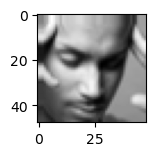

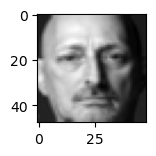

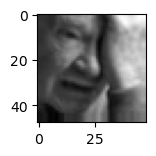

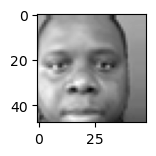

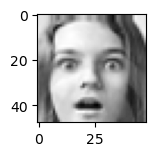

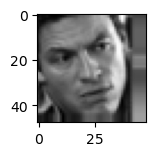

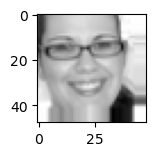

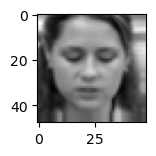

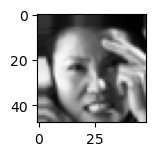

In [61]:
for X_batch, y_batch in train_datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(48, 48, 1),cmap = plt.cm.gray)
        plt.show()
    break

In [62]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure


In [63]:
def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

In [64]:
class_names = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred_raw = model.predict(x_valid)
  test_pred = np.argmax(test_pred_raw, axis=1)
  rounded_y_valid = np.argmax(y_valid, axis=1)

  # Calculate the confusion matrix.
  cm = sklearn.metrics.confusion_matrix(rounded_y_valid, test_pred)
  # Log the confusion matrix as an image summary.
  figure = plot_confusion_matrix(cm, class_names=class_names)
  cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)


## Compile Model

In [69]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=.01) ,metrics= Recall())
logdir = "logs/image/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')


In [70]:
# Start TensorBoard.
%tensorboard --logdir logs/image

class_now =  {0:1.5, 1:1.5, 2:1 ,3:4, 4:1, 5:1}

model.fit(img_iter,
          epochs=200,
          steps_per_epoch=len(x_train)/batch_size,
          # steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data= valid_iter,
          #class_weight = class_weights,
          callbacks = [tensorboard_callback, cm_callback])

# within 2% of epoch just stop 


Reusing TensorBoard on port 6006 (pid 17804), started 1 day, 3:36:48 ago. (Use '!kill 17804' to kill it.)

Epoch 1/200
883/883 [==============================] - 27s 28ms/step - loss: 1.7677 - recall_2: 0.0245 - val_loss: 1.5852 - val_recall_2: 0.1353
Epoch 2/200
883/883 [==============================] - 24s 27ms/step - loss: 1.5097 - recall_2: 0.1614 - val_loss: 1.3550 - val_recall_2: 0.2434
Epoch 3/200
883/883 [==============================] - 25s 28ms/step - loss: 1.3988 - recall_2: 0.2142 - val_loss: 1.3256 - val_recall_2: 0.2301
Epoch 4/200
883/883 [==============================] - 26s 29ms/step - loss: 1.3618 - recall_2: 0.2313 - val_loss: 1.2999 - val_recall_2: 0.2467
Epoch 5/200
883/883 [==============================] - 26s 29ms/step - loss: 1.3289 - recall_2: 0.2552 - val_loss: 1.2363 - val_recall_2: 0.3820
Epoch 6/200
883/883 [==============================] - 26s 29ms/step - loss: 1.2767 - recall_2: 0.2794 - val_loss: 1.1739 - val_recall_2: 0.3347
Epoch 7/200
883/883 [==============================] - 24s 28ms/step - loss: 1.2528 - recall_2: 0.3002 - val_loss: 1.2098 - val_re

In [71]:
model.save('facial_model')

INFO:tensorflow:Assets written to: facial_model\assets


INFO:tensorflow:Assets written to: facial_model\assets


In [65]:
#logdir_test = "logs/image/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir_test)

In [72]:
#evaluate the model
test_loss, test_recall = model.evaluate(test_iter)
print('Test accuracy:', test_recall)

111/111 [==============================] - 1s 12ms/step - loss: 0.9745 - recall_2: 0.6521
Test accuracy: 0.6521369814872742


So the model has about a 65% recall on test data, which is the best I can do currently, splitting up into models that handle the positive and negative emotions separately, having cleaner data, and generating more data so the classes are balanced may improve recall, but data augementation was already used.